## Naive LR on all selected variables
- Used all selected var from VAR MAP
- Filled NA with mean

In [1]:
import sys, os
DMOL_DIR = "/Users/Henryye/research/shaf/DMOL"
sys.path.append(os.path.join(DMOL_DIR, "utils"))

from ml_utils import *


import numpy as np
import pandas as pd
import math
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from astropy.stats import median_absolute_deviation

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/class_data.csv")
df_proc = preprocess_df(df, verbose = False)

In [14]:
def get_metrics(y_true, y_pred, k):
    print("MSE:  {}".format(mean_squared_error(y_true, y_pred)))
    print("MAE:  {}".format(mean_absolute_error(y_true, y_pred)))
    R = r2_score(y_true, y_pred)
    n = len(y_true)
    adjR = 1 - (1-R**2)*(n-1) / (n-k-1)
    print("r-squared:  {}".format(R))
#     print("Adjusted r-squared:  {}".format(adjR))
    
def plot_results(y_true, y_pred):
    plt.figure(figsize = (8, 3))
    plt.scatter(y_true, y_pred)
    plt.plot(np.linspace(min(y_true), max(y_true)), np.linspace(min(y_true), max(y_true)), '-r')
    plt.xlabel("y true", fontsize = 12)
    plt.ylabel("y pred", fontsize = 12)
    plt.show()

def mad_remove_outlier(df):
    for i, c in enumerate(list(df.columns)):
        mad, mu = median_absolute_deviation(df[c]), df[c].mean()
        for idx in df.index:
            if df.loc[idx, c] > mu + 3 * mad:
#                 print("upper:  bef: {}, after: {}".format(df.loc[idx, c], mu + 3 * mad))
                df.loc[idx, c] = mu + 3 * mad
            elif df.loc[idx, c] < mu - 3 * mad:
#                 print("lower:  bef: {}, after: {}".format(df.loc[idx, c], mu - 3 * mad))
                df.loc[idx, c] = mu - 3 * mad
    return df
        
def construct_X(df, var_map_curr, n_comp = None, verbose = False):
    X = pd.DataFrame()
    pca = KernelPCA(n_components=n_comp, kernel="poly", degree=3) if n_comp is not None else None
    for construct in var_map_curr["Quant"]:
        temp = df[var_map_curr["Quant"][construct]].copy()
        temp = temp.fillna(temp.median())  # use median to fillna
        temp = mad_remove_outlier(temp)    # use mad to remove outliers
        if n_comp is None:
            temp_mean = pd.DataFrame(temp.mean(axis=1))
            temp_mean.columns = ["{}_mean".format(construct)]
            X = pd.concat([X, temp_mean], axis = 1)
        else:
            if len(var_map_curr["Quant"][construct]) < n_comp:
                X = pd.concat([X, temp.copy()], axis = 1)
            else:
                temp_pca = pd.DataFrame(pca.fit_transform(temp))
                temp_pca.columns = ["{}_PC{}".format(construct, i) for i in range(1, n_comp+1)]
                X = pd.concat([X, temp_pca], axis = 1)
    return X

def train_model(df, week_num, n_comp = None, use_fr = False, plot = False, verbose = False):
    var_map_curr = NEW_VAR_MAP["week_{}".format(week_num)]
    X, y = construct_X(df, var_map_curr, n_comp, verbose), df["gr_revq{}".format(week_num)]
    for gr in ["gr_revq{}".format(i) for i in range(max(1, week_num-1), week_num)]:
        X[gr] = df[gr]
    print(X.shape)
    
    # min max Std
    min_max_scaler = MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
    reg = Lasso(alpha=0.3).fit(X_train, y_train)
    
    print("Training Score:  ")
    y_train_pred = reg.predict(X_train)
    get_metrics(y_train, y_train_pred, X_train.shape[1])
    print('\n')
    print("Testing Score:   ")
    y_test_pred = reg.predict(X_test)
    get_metrics(y_test, y_test_pred, X_test.shape[1])
    
    if plot:
        print("Training plots:  ")
        plot_results(y_train, y_train_pred)
        print("Testing plots：  ")
        plot_results(y_test, y_test_pred)

Week 1
(99, 54)
Training Score:  
MSE:  18.039217301910927
MAE:  3.228513653983234
r-squared:  0.4691072703820405


Testing Score:   
MSE:  58.60448575049903
MAE:  6.808704118995356
r-squared:  -5.9915213647201915
Training plots:  


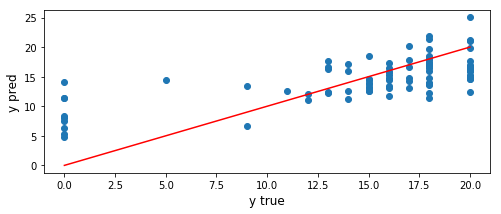

Testing plots：  


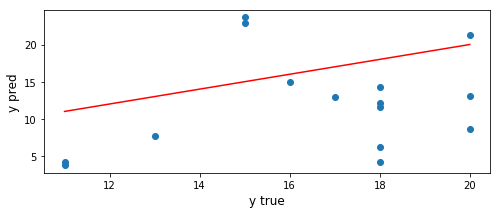




Week 2
(99, 36)
Training Score:  
MSE:  18.239730519220693
MAE:  3.133742843857072
r-squared:  0.4728949982445285


Testing Score:   
MSE:  52.28127078731848
MAE:  4.870256070216123
r-squared:  -0.33279922129465844
Training plots:  


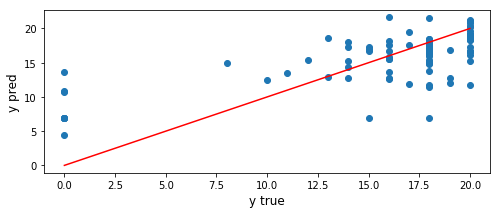

Testing plots：  


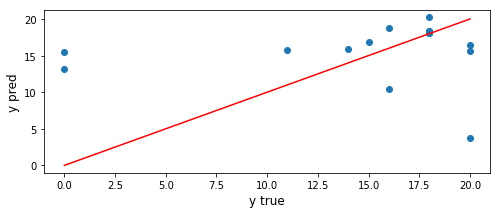




Week 3
(99, 33)
Training Score:  
MSE:  13.05054246916888
MAE:  2.580423836440779
r-squared:  0.6131548157349369


Testing Score:   
MSE:  34.0399683565596
MAE:  3.8828328985186404
r-squared:  -0.52084846708219
Training plots:  


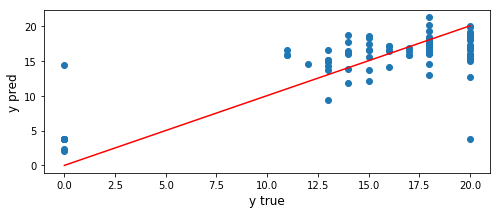

Testing plots：  


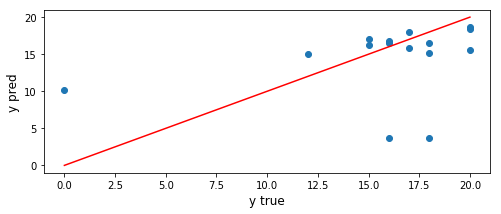




Week 4
(99, 37)
Training Score:  
MSE:  8.485259765671207
MAE:  2.327049133124202
r-squared:  0.7522551893234684


Testing Score:   
MSE:  36.41094772597252
MAE:  4.3713857102514
r-squared:  -0.34390801153934025
Training plots:  


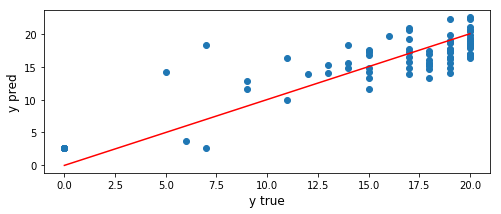

Testing plots：  


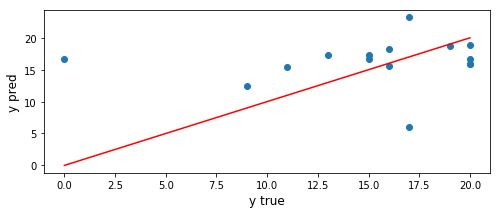




Week 5
(99, 36)
Training Score:  
MSE:  11.904701447348007
MAE:  2.2973003736404447
r-squared:  0.7251754521132561


Testing Score:   
MSE:  30.13811855344757
MAE:  3.9378651965971376
r-squared:  0.3091812678763546
Training plots:  


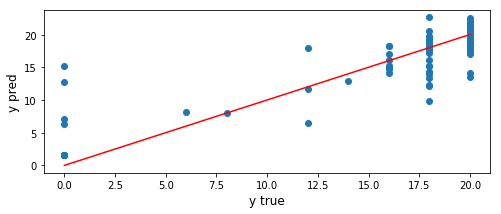

Testing plots：  


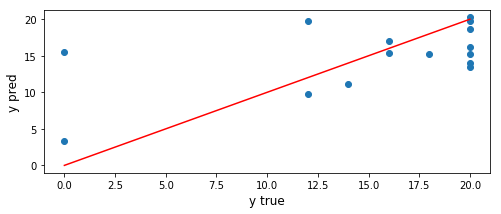

In [15]:
# using 3 PC: can see after the third principal, the var explained is very small
for week_num in range(1, 6):
    print("Week {}".format(week_num))
    train_model(df_proc, week_num, n_comp=3, use_fr = False, plot = True, verbose = True)
    print('\n\n')

Week 1
(99, 21)
Training Score:  
MSE:  27.582435976206067
MAE:  3.9015583458286804
r-squared:  0.1882511042555347


Testing Score:   
MSE:  20.83553040511269
MAE:  4.116043768809543
r-squared:  -1.4856809868241543
Training plots:  


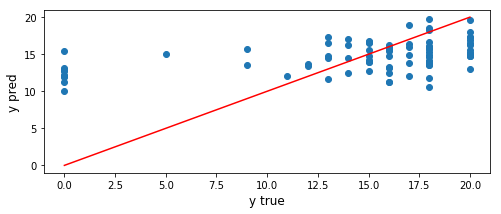

Testing plots：  


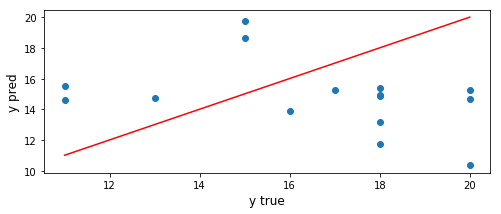




Week 2
(99, 16)
Training Score:  
MSE:  23.559696097542446
MAE:  3.352934819081715
r-squared:  0.3191547627434974


Testing Score:   
MSE:  37.25818223982499
MAE:  3.930724131294365
r-squared:  0.050182301839947985
Training plots:  


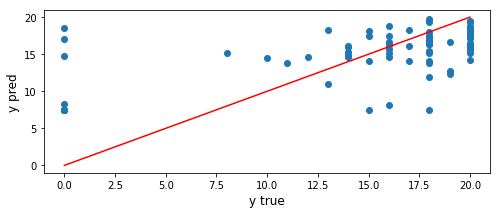

Testing plots：  


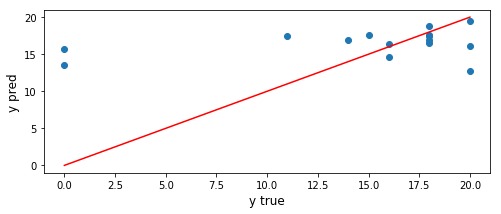




Week 3
(99, 15)
Training Score:  
MSE:  13.686190937833915
MAE:  2.7005453753392636
r-squared:  0.5943128749060826


Testing Score:   
MSE:  35.77206254417812
MAE:  3.9026665874222415
r-squared:  -0.5982355187529937
Training plots:  


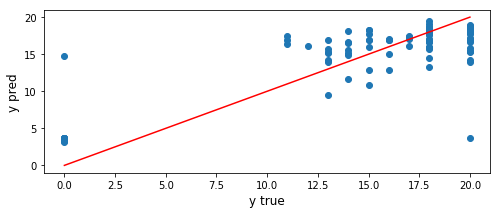

Testing plots：  


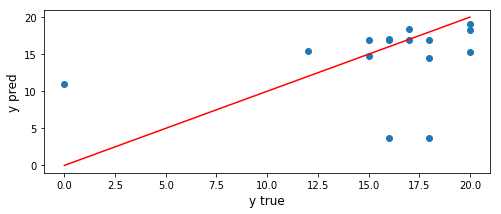




Week 4
(99, 17)
Training Score:  
MSE:  9.706588008364701
MAE:  2.3933205475199797
r-squared:  0.7165959705586948


Testing Score:   
MSE:  42.86270543982519
MAE:  4.3867492442271345
r-squared:  -0.5820388326707133
Training plots:  


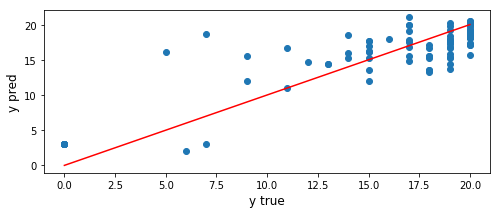

Testing plots：  


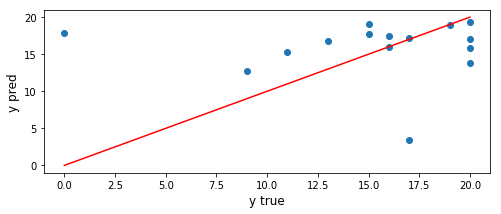




Week 5
(99, 16)
Training Score:  
MSE:  15.051133847015759
MAE:  2.418636515168232
r-squared:  0.6525388668515967


Testing Score:   
MSE:  34.62521297300665
MAE:  4.037462004966595
r-squared:  0.20632916473853957
Training plots:  


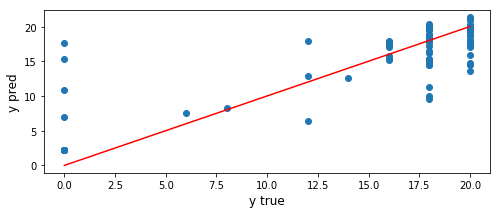

Testing plots：  


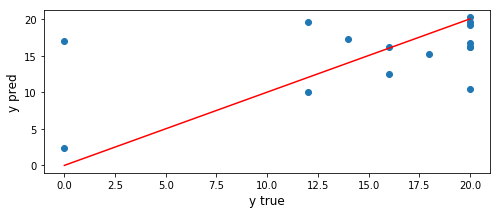

In [16]:
# using the mean
for week_num in range(1, 6):
    print("Week {}".format(week_num))
    train_model(df_proc, week_num, use_fr = False, plot = True, verbose = True)
    print('\n\n')